In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#Downloading TESS dataset
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 98% 420M/428M [00:04<00:00, 125MB/s]
100% 428M/428M [00:04<00:00, 109MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import numpy as np
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [ ]:
path="/content/TESS Toronto emotional speech set data/YAF_disgust/YAF_back_disgust.wav"
data, sample_rate = librosa.load(path)

In [ ]:
ipd.Audio(path)

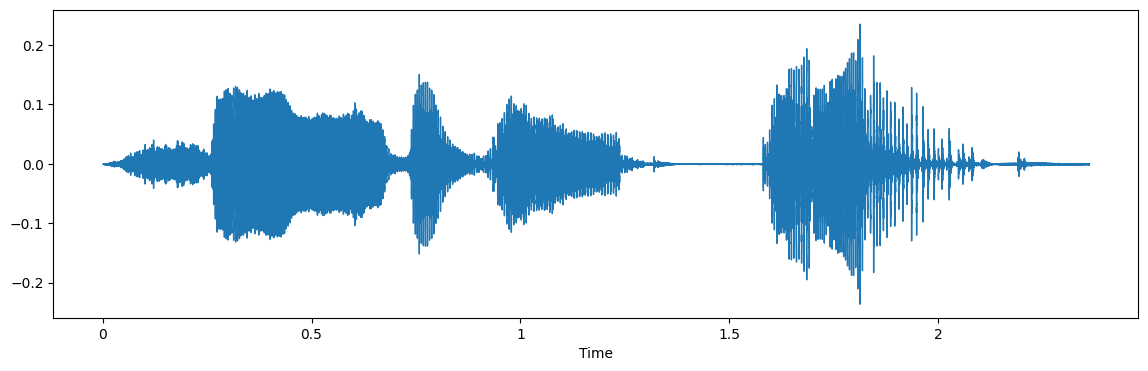

In [ ]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)

In [ ]:
paths = []
labels =[]
for dirname, _, filenames in os.walk('/content/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label= label.replace('.wav', '')
        labels.append(label.lower())
    if len(paths) == 2800:
         break

print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
len(paths)

2800

In [ ]:
labels[:10]

['fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear']

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

In [ ]:
df = pd.DataFrame()
df['Path'] = paths
df['label'] = labels
df.head()

,Path,label
0,/content/TESS Toronto emotional speech set dat...,fear
1,/content/TESS Toronto emotional speech set dat...,fear
2,/content/TESS Toronto emotional speech set dat...,fear
3,/content/TESS Toronto emotional speech set dat...,fear
4,/content/TESS Toronto emotional speech set dat...,fear


In [ ]:
df['label'].value_counts()

fear       400
angry      400
happy      400
sad        400
disgust    400
neutral    400
ps         400
Name: label, dtype: int64

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc
extract_mfcc(df['Path'][0])

array([-4.4346262e+02,  7.6602608e+01,  2.9809891e+01, -1.8152559e-02,
       -1.7125965e+01, -8.9288330e+00, -1.3832372e+01,  4.5813174e+00,
       -1.4108355e+01, -4.1927037e+00, -1.3826605e+01, -7.7421350e+00,
       -9.4727097e+00,  7.5368967e+00, -6.7454143e+00,  1.2817863e+00,
       -2.3730550e+00,  1.8614354e+00, -4.6870995e-01, -7.0354075e+00,
        4.6928829e-01,  1.1997273e+01,  1.4054817e+01,  2.9037426e+01,
        2.4275160e+01,  2.2517534e+01,  1.3817835e+01,  9.0426502e+00,
        3.2797484e+00,  2.7622988e+00, -1.0123211e+00,  3.2708941e+00,
       -6.0911500e-01, -2.9967182e+00,  3.2758946e+00,  3.1999452e+00,
       -4.2601943e+00,  1.6717669e+00, -6.9180808e+00,  1.4698288e+00],
      dtype=float32)

In [ ]:
#Audio
extract_mfcc(df['Path'][0])
X_mfcc = df['Path'].apply(lambda x: extract_mfcc(x))
X = [x for x in X_mfcc]
X = np.array(X)
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [ ]:
#Labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(512, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100)

Epoch 1/30
23/23 [==============================] - 27s 1s/step - loss: 1.5982 - accuracy: 0.3478 - val_loss: 0.8760 - val_accuracy: 0.6625
Epoch 2/30
23/23 [==============================] - 23s 999ms/step - loss: 0.9110 - accuracy: 0.6464 - val_loss: 0.7229 - val_accuracy: 0.7571
Epoch 3/30
23/23 [==============================] - 23s 1s/step - loss: 0.6297 - accuracy: 0.7808 - val_loss: 0.2942 - val_accuracy: 0.8929
Epoch 4/30
23/23 [==============================] - 22s 958ms/step - loss: 0.4169 - accuracy: 0.8723 - val_loss: 0.3884 - val_accuracy: 0.8714
Epoch 5/30
23/23 [==============================] - 22s 977ms/step - loss: 0.4032 - accuracy: 0.8781 - val_loss: 0.2923 - val_accuracy: 0.9125
Epoch 6/30
23/23 [==============================] - 22s 982ms/step - loss: 0.3171 - accuracy: 0.9179 - val_loss: 0.1652 - val_accuracy: 0.9536
Epoch 7/30
23/23 [==============================] - 22s 921ms/step - loss: 0.2385 - accuracy: 0.9375 - val_loss: 0.2869 - val_accuracy: 0.9214
Epoch

In [ ]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 3s 166ms/step - loss: 0.1180 - accuracy: 0.9696


[0.11796872317790985, 0.9696428775787354]

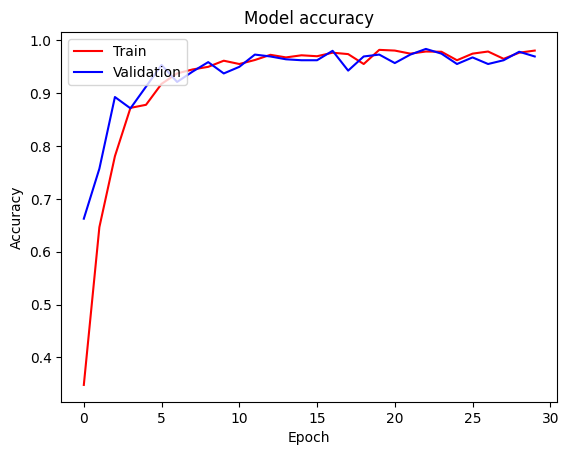

In [ ]:
#Plotting  Graphs - Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

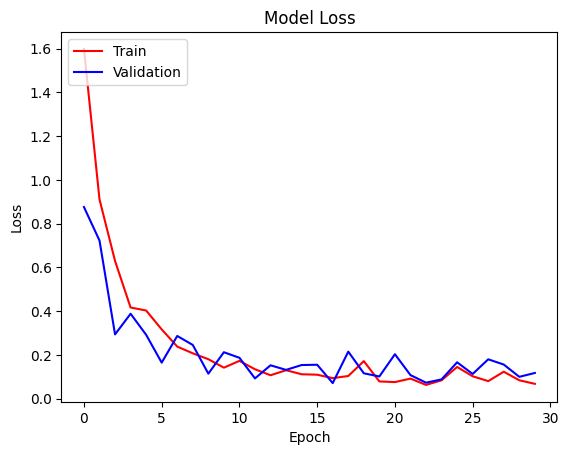

In [ ]:
#Loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()